In [3]:
import numpy as np
import mne
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import signal, ndimage
from scipy.interpolate import interp1d
import pywt
from matplotlib.colors import Normalize, LogNorm, NoNorm
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import time
from cwt_spectrogram import *

%matplotlib inline


Extracting EDF parameters from /Users/madssverker/Documents/GitHub/Bachelor_Thesis/data/PSG's/SC4041E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7709999  =      0.000 ... 77099.990 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

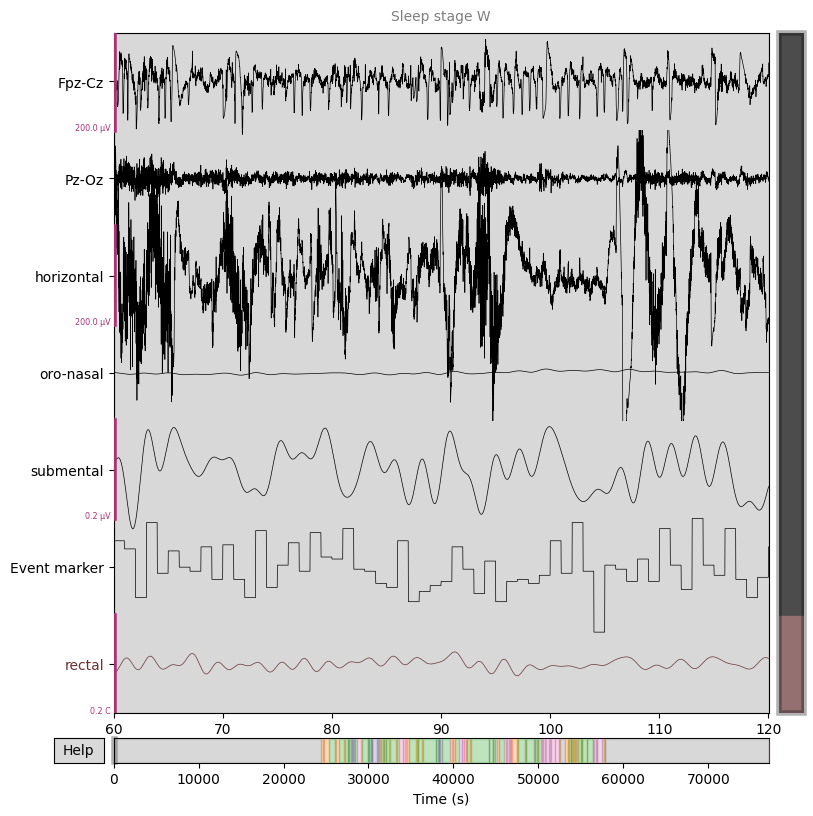

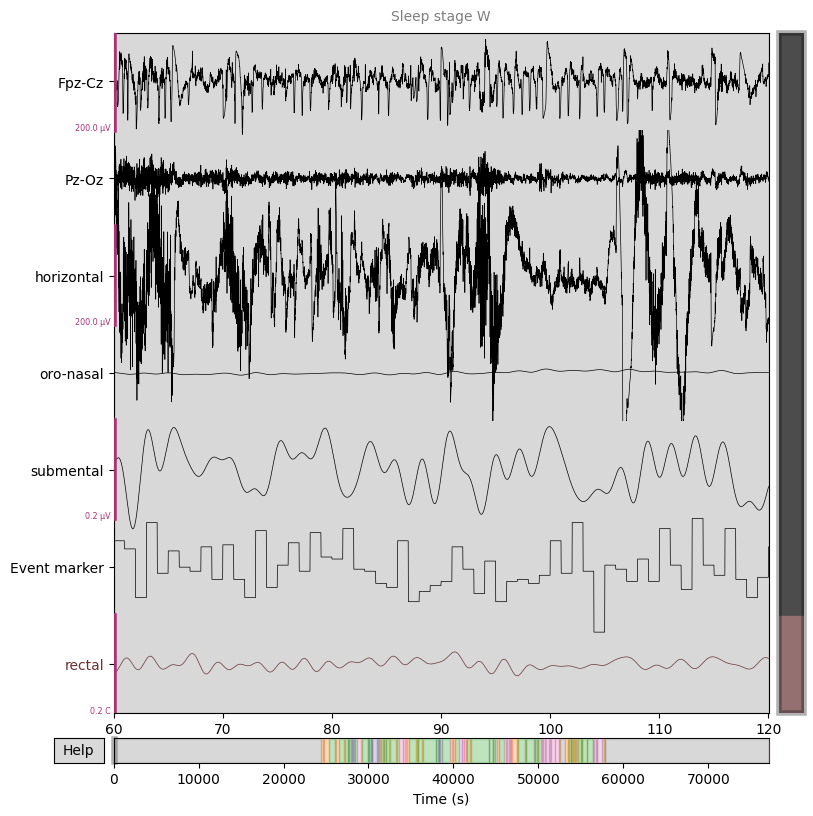

In [4]:
#Setting up paths for EDF files
#PSG = EEG
psg_path = Path("/Users/madssverker/Documents/GitHub/Bachelor_Thesis/data/PSG's")
#Hypnogram = Annotations
hypnogram_path = Path("/Users/madssverker/Documents/GitHub/Bachelor_Thesis/data/Hypnograms")

psg_file = psg_path / 'SC4041E0-PSG.edf'
hypnogram_file = hypnogram_path / 'SC4041EC-Hypnogram.edf'

raw_train = mne.io.read_raw_edf(psg_file, stim_channel="Event Marker", infer_types=True, preload=True)
raw_train.filter(l_freq = 1, h_freq = None)

annot_train = mne.read_annotations(hypnogram_file)

raw_train.set_annotations(annot_train, emit_warning=False)

raw_train.plot(
    start=60,
    duration=60,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1),
)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']


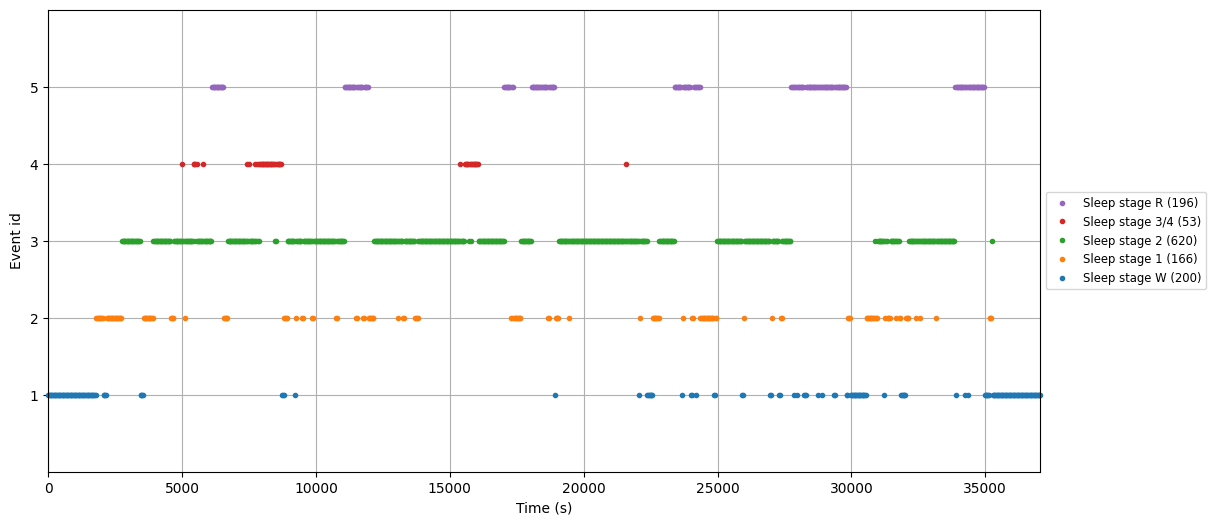

In [5]:
annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]["onset"] - 30 * 60, annot_train[-2]["onset"] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

fpz_cz_data, times = raw_train.pick_channels(['Fpz-Cz']).get_data(return_times=True)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

# # Define the fixed length of the events in seconds
# event_length_seconds = 30
# # Convert event length to samples based on the sampling frequency
# event_length_samples = event_length_seconds * raw_train.info['sfreq']
# print(raw_train.info['sfreq'])
# # Sort events_train by start time
# events_train = events_train[np.argsort(events_train[:, 0])]
# # Initialize non-overlapping events list
# non_overlapping_events = []

# # Iterate through events
# for i, event in enumerate(events_train):
#     event_start = event[0]
#     print(event_start)
#     event_end = event_start + event_length_samples
    
#     # Check for overlap with subsequent events
#     overlap = False
#     for next_event in events_train[i+1:]:
#         next_event_start = next_event[0]
#         next_event_end = next_event_start + event_length_samples
#         if event_end > next_event_start:
#             overlap = True
#             break
    
#     # If no overlap, add the event to non_overlapping_events
#     if not overlap:
#         non_overlapping_events.append(event)

# # Convert the list of non-overlapping events to a numpy array
# non_overlapping_events = np.array(non_overlapping_events)


# create a new event_id that unifies stages 3 and 4
event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3/4": 4,
    "Sleep stage R": 5,
}

# plot events
fig = mne.viz.plot_events(
    events_train,
    event_id=event_id,
    sfreq=raw_train.info["sfreq"],
    first_samp=events_train[0, 0],
)

# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [6]:
tmax = 30.0 - 1.0 / raw_train.info["sfreq"]  # tmax in included

epochs_train = mne.Epochs(
    raw=raw_train,
    events=events_train,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
# del raw_train

print(epochs_train.event_id)
output_file = 'eeg_events.csv'
np.savetxt(output_file, epochs_train.get_data().squeeze(), delimiter=',')

print(f"Data extracted and saved to {output_file}")

Not setting metadata
1235 matching events found
No baseline correction applied
0 projection items activated
{'Sleep stage W': 1, 'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3/4': 4, 'Sleep stage R': 5}
Using data from preloaded Raw for 1235 events and 3000 original time points ...
0 bad epochs dropped
Data extracted and saved to eeg_events.csv


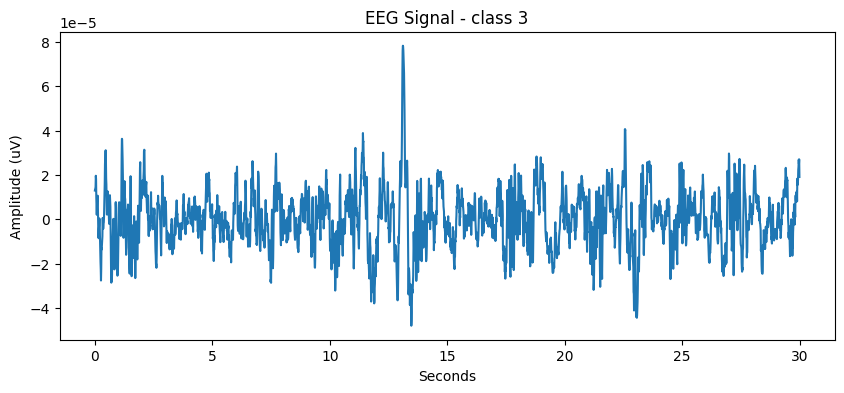

In [7]:
data = np.loadtxt(output_file, delimiter=',')

N = 486
# Extract the first row
first_row = data[N, :]
# print(len(first_row))
# Plot the signal
plt.figure(figsize=(10, 4))
time_step = np.arange(0, len(first_row)) * (1 / raw_train.info['sfreq'])
plt.plot(time_step, first_row)
plt.title('EEG Signal - class ' f'{epochs_train.events[N][2]}')
plt.xlabel('Seconds')
plt.ylabel('Amplitude (uV)')
plt.show()

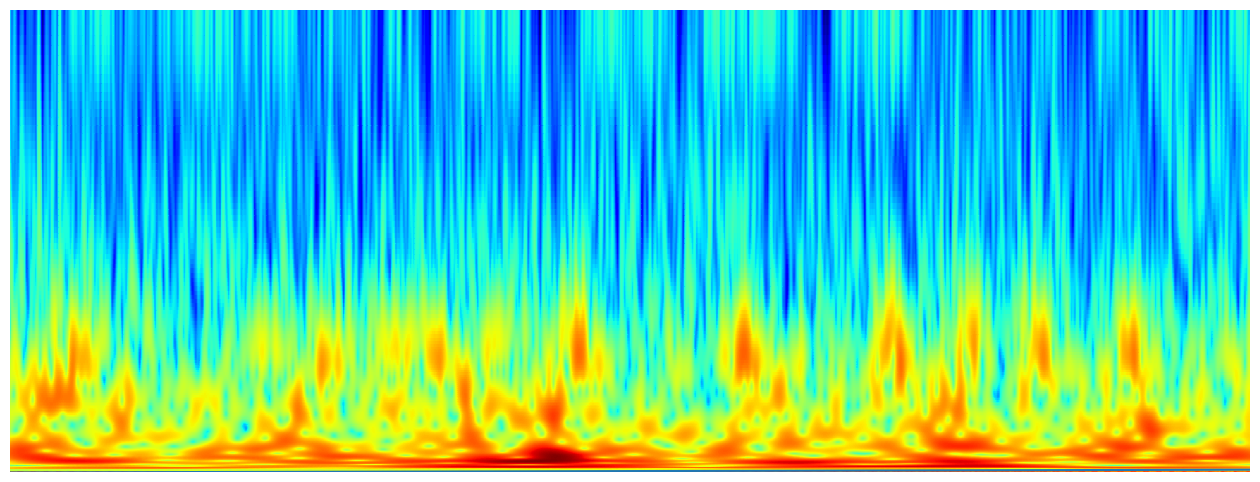

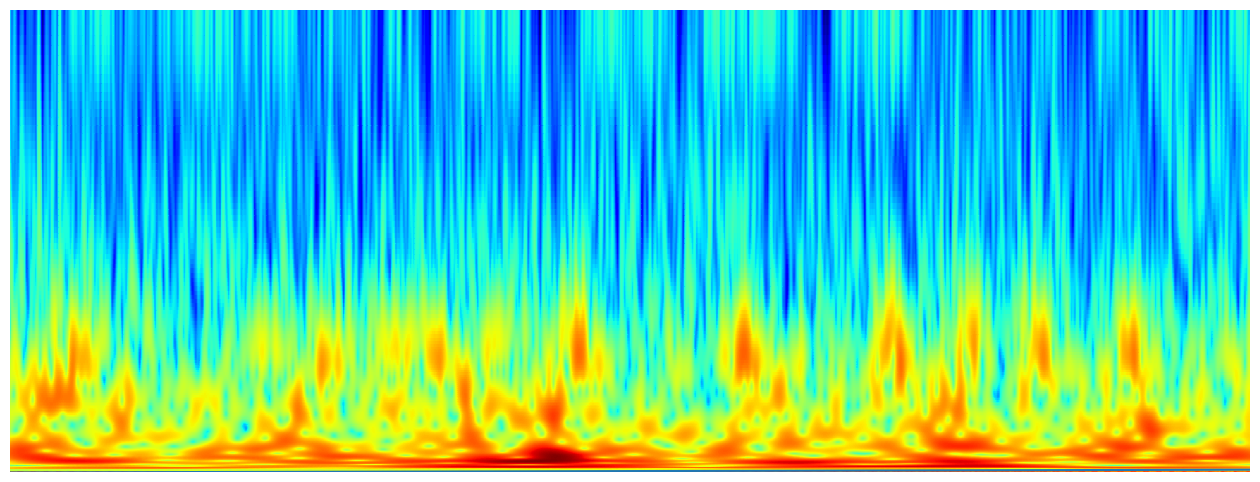

In [12]:
plt.rcParams['figure.figsize'] = (16, 6)

###########################################################################
# calculate spectrogram

# t0 = time.time()
power, times, frequencies, coif = cwt_spectrogram(first_row, 100, nNotes=30)

###########################################################################
# plot
spectrogram_plot(power, times, frequencies, coif, cmap = 'jet', norm = LogNorm(), colorbar = None)

In [33]:
# # Set the desired number of events per label
# events_per_label = 20

# # Create a dictionary to store the count of events for each label
# event_count = {label: 0 for label in event_id.keys()}

# # Initialize an empty list to store selected events
# selected_events = []

# # Iterate through all events and select 20 events per label
# for event in events_train:
#     event_label = list(event_id.keys())[list(event_id.values()).index(event[2])]
    
#     if event_count[event_label] < events_per_label:
#         selected_events.append(event)
#         event_count[event_label] += 1

#     # Break the loop once 20 events per label are selected
#     if all(count == events_per_label for count in event_count.values()):
#         break

# # Convert the selected events list back to an array
# selected_events = np.array(selected_events)

# # Plot the selected events
# fig = mne.viz.plot_events(
#     selected_events,
#     event_id=event_id,
#     sfreq=raw_train.info["sfreq"],
#     first_samp=selected_events[0, 0],
# )

# # Create a new Epochs object with only 20 events per label
# selected_epochs = mne.Epochs(
#     raw=raw_train,
#     events=selected_events,
#     event_id=event_id,
#     tmin=0.0,
#     tmax=tmax,
#     baseline=None,
# )

# # Extract and save the data corresponding to the selected events
# selected_data = selected_epochs.get_data().squeeze()

# # Save the selected events to a CSV file
# output_file = 'selected_eeg_events.csv'
# np.savetxt(output_file, selected_data, delimiter=',')

# print(f"Data extracted and saved to {output_file}")
# print(selected_epochs.events[:, 2])


In [1]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from cwt_spectrogram import *

csv_file_path = 'eeg_events.csv'
df = pd.read_csv(csv_file_path)

spectro_folder = Path('/Users/madssverker/Documents/bachelor/SpectroImg_folder')
os.makedirs(spectro_folder, exist_ok=True)

dataset = []  # List to store image paths and labels

for i, row in df.iterrows():
    signal_id = i
    power, times, frequencies, coif = cwt_spectrogram(row, 100, nNotes=24)

    spectro_plot = spectrogram_plot(power, times, frequencies, coif, cmap = 'jet', norm = LogNorm(), colorbar = None)

    fig = spectro_plot

    spectrogram_folder = f'{spectro_folder}/spectrogram_{signal_id}'
    os.makedirs(spectrogram_folder, exist_ok=True)

    spectro_filename = f'{spectrogram_folder}/spectrogram.png'
    fig.savefig(spectro_filename, bbox_inches = 'tight', pad_inches = 0)
    plt.close(fig)

    # Integrate the label into the spectrogram folder
    label = epochs_train.events[i][2]  # Assuming epochs_train is your label source
    label_filename = f'{spectrogram_folder}/label.txt'
    with open(label_filename, 'w') as label_file:
        label_file.write(str(label))

    # Add image path and label to the dataset list
    dataset.append((spectro_filename, label))

print('spectrograms and labels saved successfully')

In [1]:
# import pandas as pd
# from pathlib import Path
# import os
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# import os
# os.environ["PYDEVD_USE_CYTHON"] = "NO"

# # Function to generate spectrogram and save it
# def generate_spectrogram(row, signal_id, spectro_folder):
#     power, times, frequencies, coif = cwt_spectrogram(row, fs = raw_train.info['sfreq'], nNotes=30)
#     spectro_plot = spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), colorbar=None)
#     fig = spectro_plot
#     spectrogram_folder = f'{spectro_folder}/spectrogram_{signal_id}'
#     os.makedirs(spectrogram_folder, exist_ok=True)
#     spectro_filename = f'{spectrogram_folder}/spectrogram.png'
#     fig.savefig(spectro_filename, bbox_inches='tight', pad_inches=0)
#     plt.close(fig)
#     return spectro_filename

# # Function to save label
# def save_label(signal_id, label, spectro_folder):
#     label_filename = f'{spectro_folder}/spectrogram_{signal_id}/label.txt'
#     with open(label_filename, 'w') as label_file:
#         label_file.write(str(label))


